In [1]:
import anndata as ad
import scanpy as sc, pandas as pd, numpy as np
import glob2, os, re
from collections import Counter
from openpyxl import load_workbook
from collections import defaultdict
# using datetime module
import datetime
import functools


In [2]:
sc.settings.set_figure_params(dpi_save=400, format='png', color_map = 'viridis_r')
sc.settings.autosave = True
sc.settings.autoshow = True
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_version_and_date()

Running Scanpy 1.7.2, on 2021-08-29 13:36.


In [3]:
t2g = pd.read_csv("Hs_allchr_MT.txt", skiprows=1, usecols=range(2),names=["gene_id", "gene_name"], sep="\t")
t2g.index = t2g.gene_id
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

In [4]:
cs_s_genes = pd.read_csv('cc_s_genes.txt', names=['genes'])

In [5]:
cs_g2m_genes = pd.read_csv('cc_g2m_genes.txt', names=['genes'])

In [6]:
covariates_file = pd.read_csv('All_logs.tsv', sep = "\t", header=[0, 1, 2])

In [7]:
covariates_file.head()

LAB                                                  STAR  \
  BATCH                  SAMPLE    BATCH                  REG   
  ROUND                  SAMPLE PREPARER REP        JOB_START   
0     2  NPSAD-20201117-A1-cDNA        A   1  Jul/08/10:45:40   
1     2  NPSAD-20201110-A1-cDNA        A   1  Jul/08/02:02:51   
2     2  NPSAD-20201117-C2-cDNA        C   2  Jul/11/13:38:02   
3     2  NPSAD-20201112-A2-cDNA        A   2  Jul/11/15:05:17   
4     2  NPSAD-20201125-A2-cDNA        A   2  Jul/08/10:39:21   

                                                                        ...  \
                                                                        ...   
         MAP_START       JOB_FINISH MAP_SPEED     N_READS AVG_READ_LEN  ...   
0  Jul/08/13:09:16  Jul/08/17:37:24    391.20  1748251072           90  ...   
1  Jul/08/03:27:24  Jul/08/06:29:52    404.36  1229717948           90  ...   
2  Jul/11/15:11:49  Jul/11/18:43:51    398.67  1408846088           90  ...   
3  Jul/11/16:38:14  Jul/11/21:01:39    338.07  1484234487           90  ...   
4  Jul/08/12:05:58  Jul/08/15:15:35    444.01  1403192053           90  ...   

          cellranger                                         \
               DEMUX                                          
  N_DOUBLET_CELLS_CS N_NEGATIVE_CELLS_CS N_DOUBLET_CELLS_MS   
0               3276                  61               3369   
1               5789                  46               5785   
2               5532                  52               5397   
3               4164                  27               4393   
4               4697                  97               5050   

                                                                             \
                                                                              
  N_NEGATIVE_CELLS_MS N_DOUBLET_CELLS_HD N_NEGATIVE_CELLS_HD N_CELLS_COMMON   
0                 618               3019                1442          11926   
1                1082               5688                1199          14830   
2                 473               5375                 800          15220   
3                1132               3621                2615          12960   
4                 682               4723                1328          15134   

                                                      \
                                                       
                              N_CELLS_AFTER_DEMUX_CS   
0  M83930:3858,M639636:3369,M8975:2656,H1560:1836...   
1  M84936:3893,M96977:3260,R86712535:2669,M74724:...   
2  M86494:3619,M38454:2965,M76678:2650,M64974:263...   
3  H653:3900,M1176:3812,H898:3455,M45480:2899,H13...   
4  M6160:4133,H1187:3677,M7107:3403,M86761:2829,M...   

                                                      \
                                                       
                              N_CELLS_AFTER_DEMUX_MS   
0  M83930:3732,M639636:3240,M8975:2288,H1560:1858...   
1  M84936:3681,M96977:3217,M99118:2443,M74724:242...   
2  M86494:3867,M38454:2671,M76678:2586,M64974:257...   
3  M1176:4235,H898:3557,H653:3161,H1357:1977,M454...   
4  M6160:3857,M7107:3400,H1187:3234,M86761:2726,M...   

                                                      
                                                      
                              N_CELLS_AFTER_DEMUX_HD  
0  M83930:3703,M639636:2736,M8975:2119,H1560:1959...  
1  M84936:3732,M96977:3009,M99118:2657,M99345:241...  
2  M86494:3925,M64974:2610,M76678:2549,M39282:254...  
3  M1176:3677,H898:3115,H653:2890,H1357:2286,M454...  
4  M6160:3605,H1187:3262,M7107:3259,M73140:2777,M...  

[5 rows x 189 columns]

In [8]:
select = 'STAR'

In [9]:
def save_annd(ann_d, suff):
    if select == 'STAR':
        ann_d.write(f'STAR_202_samples_hvg_{suff}.h5ad')
    else:
        ann_d.write(f'cellR_202_samples_hvg_{suff}.h5ad')

In [10]:
adata = ad.read('STAR_202_samples_hvg_hpy_umap.h5ad')

In [11]:
adata

AnnData object with n_obs × n_vars = 3518365 × 6160
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'batch', 'round_num', 'prep', 'rep', 'SubID_hd', 'HTO_n_hd', 'SubID_cs', 'SubID_ms', 'HTO_n_cs', 'HTO_n_ms', 'batch_1'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_1_colors', 'hvg', 'neighbors', 'pca', 'prep_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [6]:
#if select == "STAR":
 #   adata = ad.read('202_Samples_combo_STARsolo.h5ad')
#else:
 #   adata = ad.read('202_Samples_combo_cellR.h5ad')

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [26]:
adata.obs['batch_1'] = ['-'.join(val.split('-')[:2]) for val in adata.obs['batch'].to_list() ]

In [7]:
adata

AnnData object with n_obs × n_vars = 3518365 × 6160
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'batch', 'round_num', 'prep', 'rep', 'SubID_hd', 'HTO_n_hd', 'SubID_cs', 'SubID_ms', 'HTO_n_cs', 'HTO_n_ms'

In [8]:
# preserve counts
adata.layers["counts"] = adata.X.copy()

In [9]:
# Total-count normalize (library-size correct) the data matrix X to 1M i.e. CPM
sc.pp.normalize_total(adata, target_sum=1e6)


# Logarithmize the data
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:44)


In [10]:
adata.obs_names_make_unique()

In [11]:
adata

AnnData object with n_obs × n_vars = 3518365 × 6160
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'batch', 'round_num', 'prep', 'rep', 'SubID_hd', 'HTO_n_hd', 'SubID_cs', 'SubID_ms', 'HTO_n_cs', 'HTO_n_ms'
    uns: 'log1p'
    layers: 'counts'

In [13]:
a = [ b for b in adata.obs_names.to_list() if '-' in b ]

In [15]:
# Common barcodes
len(a)

1250916

In [12]:
check_sub = set(adata[adata.obs.batch == 'NPSAD-20201117-A1-cDNA'].obs.SubID_cs.to_list())

In [13]:
check_sub.remove('Not a Singlet')

In [14]:
check_sub

{'H1560', 'M12451', 'M18537', 'M639636', 'M83930', 'M8975'}

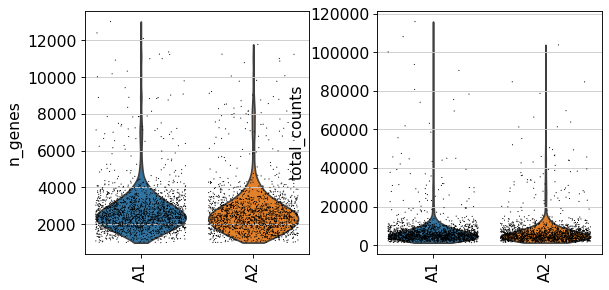

In [70]:
sc.pl.violin(adata[adata.obs['SubID_cs'] == 'H1560'], ['n_genes', 'total_counts'], groupby='prep', jitter=0.4, multi_panel=True, rotation=90, show=True, save=False)

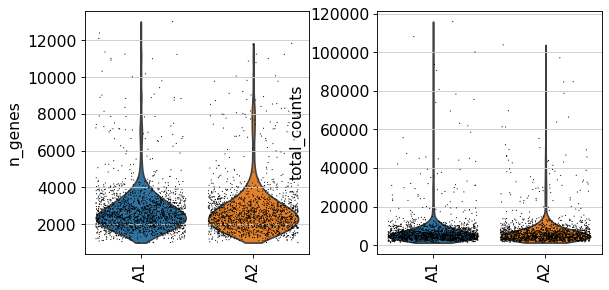

In [71]:
sc.pl.violin(adata[adata.obs['SubID_ms'] == 'H1560'], ['n_genes', 'total_counts'], groupby='prep', jitter=0.4, multi_panel=True, rotation=90, show=True, save=False)

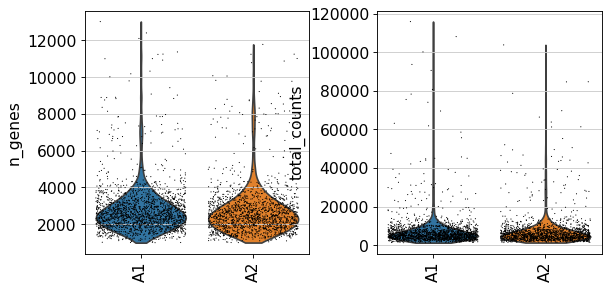

In [72]:
sc.pl.violin(adata[adata.obs['SubID_hd'] == 'H1560'], ['n_genes', 'total_counts'], groupby='prep', jitter=0.4, multi_panel=True, rotation=90, show=True, save=False)

In [ ]:
sc.pl.violin(adata[adata.obs['SubID_hd'] == 'H1560'], ['n_genes', 'total_counts'], groupby='prep', jitter=0.4, multi_panel=True, rotation=90, show=True, save=False)

In [16]:
sc.pp.highly_variable_genes(adata, n_top_genes=1000)
sc.pl.highly_variable_genes(adata, save= 'STAR_Top_1000_hvg.png' if select == 'STAR' else 'cellR_Top_1000_hvg.png')

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:03:47)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [17]:
sc.tl.pca(adata, svd_solver='arpack')
print("\t\t\tDone with pca")

# Scree Plot
sc.pl.pca_variance_ratio(adata, save='STAR_scree_high_var_1k.png' if select == 'STAR' else 'cellR_scree_high_var_1k.png')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:08:21)


			Done with pca


In [20]:
adata

AnnData object with n_obs × n_vars = 3518365 × 6160
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'batch', 'round_num', 'prep', 'rep', 'SubID_hd', 'HTO_n_hd', 'SubID_cs', 'SubID_ms', 'HTO_n_cs', 'HTO_n_ms'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [35]:
Counter(adata.obs.pct_counts_mito)

Counter({0.0: 3518365})

In [15]:
hvg_subset = adata.var_names[adata.var['highly_variable'] == True]

In [16]:
hvg_subset[:10]

Index(['ENSG00000248527_index', 'ENSG00000169504_index',
       'ENSG00000163873_index', 'ENSG00000231606_index',
       'ENSG00000229846_index', 'ENSG00000224609_index',
       'ENSG00000231252_index', 'ENSG00000185483_index',
       'ENSG00000237928_index', 'ENSG00000158966_index'],
      dtype='object')

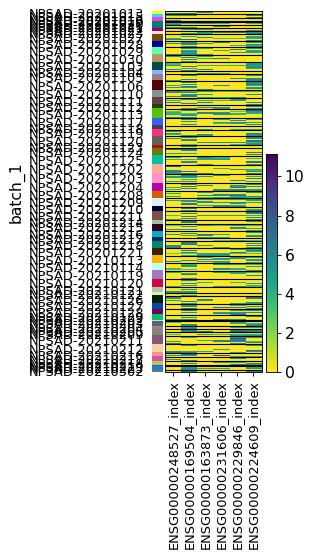

In [39]:
sc.pl.heatmap(adata, var_names = hvg_subset[:6], groupby='batch_1', save='STAR_Heatmap_hvg_5.png' if select == 'STAR' else 'cellR_Heatmap_hvg_5.png')

In [32]:
adata.obs['batch_1'] = [('-'.join(val.split('-')[:3]))[:-1] for val in adata.obs['batch'].to_list() ]

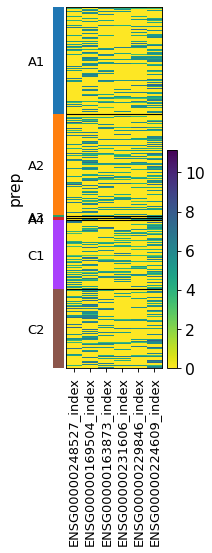

In [40]:
sc.pl.heatmap(adata, var_names = hvg_subset[:6], groupby='prep', save='STAR_Heatmap_prep_5.png' if select == 'STAR' else 'cellR_Heatmap_prep_5.png')

In [12]:
uniq_class_cells = adata[(adata.obs['HTO_n_cs'] == adata.obs['HTO_n_ms']) & (adata.obs['HTO_n_cs'] == adata.obs['HTO_n_hd'])]

In [13]:
uniq_class_cells

View of AnnData object with n_obs × n_vars = 2517912 × 6160
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'batch', 'round_num', 'prep', 'rep', 'SubID_hd', 'HTO_n_hd', 'SubID_cs', 'SubID_ms', 'HTO_n_cs', 'HTO_n_ms', 'batch_1'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_1_colors', 'hvg', 'neighbors', 'pca', 'prep_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [14]:
non_uniq_class_cells = adata[[ ind for ind in adata.obs_names.to_list() if ind not in uniq_class_cells.obs_names]]

In [15]:
non_uniq_class_cells

View of AnnData object with n_obs × n_vars = 1000453 × 6160
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'batch', 'round_num', 'prep', 'rep', 'SubID_hd', 'HTO_n_hd', 'SubID_cs', 'SubID_ms', 'HTO_n_cs', 'HTO_n_ms', 'batch_1'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_1_colors', 'hvg', 'neighbors', 'pca', 'prep_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [16]:
non_uniq_class_cells.obs.head()

,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mito,...,round_num,prep,rep,SubID_hd,HTO_n_hd,SubID_cs,SubID_ms,HTO_n_cs,HTO_n_ms,batch_1
AAACCCATCCTACAAG,4965,4961,8.509564,18648.0,9.833548,22.018447,30.137280,39.961390,54.702917,0.0,...,2,A2,2,M80772,HTO9,Not a Singlet,Not a Singlet,Not a Singlet,Not a Singlet,NPSAD-20201111
AAACGAACACACGTGC,1620,1620,7.390799,3182.0,8.065579,25.329981,34.538026,45.317410,64.802011,0.0,...,2,A2,2,Not a Singlet,Not a Singlet,R31239518,Not a Singlet,HTO10,Not a Singlet,NPSAD-20201111
AAACGAATCCTACAAG,2308,2306,7.743703,4032.0,8.302266,16.369048,22.966270,31.969246,49.851190,0.0,...,2,A2,2,R22202022,HTO7,R22202022,Not a Singlet,HTO7,Not a Singlet,NPSAD-20201111
AAAGAACCAAATCCCA,2840,2840,7.951911,6253.0,8.740977,22.677115,29.873661,39.005277,54.965617,0.0,...,2,A2,2,R22202022,HTO7,R22202022,Not a Singlet,HTO7,Not a Singlet,NPSAD-20201111
AAAGAACCATTGCCTC,2519,2518,7.831617,6757.0,8.818482,22.214000,30.871689,41.764096,59.804647,0.0,...,2,A2,2,Not a Singlet,Not a Singlet,R31239518,R31239518,HTO10,HTO10,NPSAD-20201111


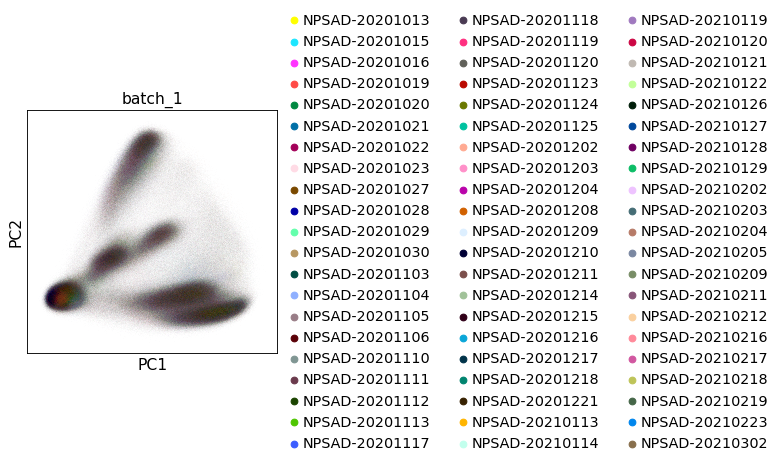

In [23]:
sc.pl.pca(adata, components='1,2', color='batch_1', color_map='viridis', save=False, show=True)

2021-08-28 16:10:17,873 - harmonypy - INFO - Iteration 1 of 10
2021-08-28 17:01:07,549 - harmonypy - INFO - Iteration 2 of 10
2021-08-28 17:52:01,691 - harmonypy - INFO - Iteration 3 of 10
2021-08-28 18:42:47,175 - harmonypy - INFO - Iteration 4 of 10
2021-08-28 19:15:26,193 - harmonypy - INFO - Iteration 5 of 10
2021-08-28 19:39:05,946 - harmonypy - INFO - Iteration 6 of 10
2021-08-28 20:02:51,750 - harmonypy - INFO - Iteration 7 of 10
2021-08-28 20:26:31,761 - harmonypy - INFO - Converged after 7 iterations


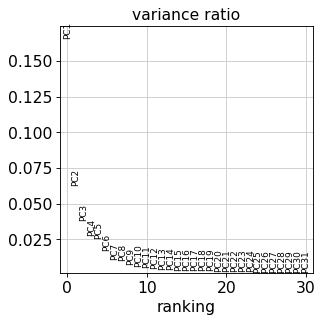

AnnData object with n_obs × n_vars = 3518365 × 6160
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'batch', 'round_num', 'prep', 'rep', 'SubID_hd', 'HTO_n_hd', 'SubID_cs', 'SubID_ms', 'HTO_n_cs', 'HTO_n_ms', 'batch_1'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_1_colors', 'hvg', 'pca', 'prep_colors'
    obsm: 'X_pca', 'X_pca_harmony'
    varm: 'PCs'
    layers: 'counts'


In [17]:
# Run Harmony (batch is NPSAD-... while SubID is the complex name/ID from Shan's spreadsheet)
sc.external.pp.harmony_integrate(adata, 'batch')

# Scree Plot 
sc.pl.pca_variance_ratio(adata, save='STAR_scree_plot_hpy_hvg_1k.png' if select == 'STAR' else 'cellR_scree_plot_hpy_hvg_1k.png')


print(adata)

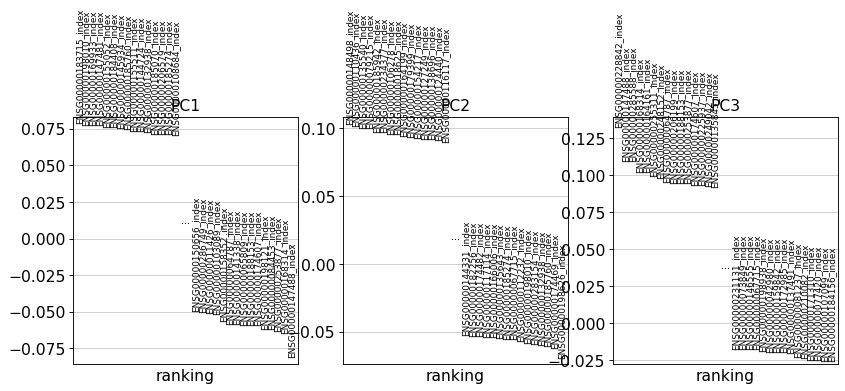

In [18]:
sc.pl.pca_loadings(adata, components = '1,2,3', save='STAR_genes_contri_3PC.png' if select == 'STAR' else 'cellR_genes_contri_3PC.png')

In [19]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony')
print("\t\t\tDone with calculating neighbours")

sc.tl.umap(adata, min_dist=0.3)
# Plot the UMAP and plot them



computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:06:32)
computing UMAP


			Done with calculating neighbours


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (1:09:56)
running Leiden clustering


KeyboardInterrupt: 

In [17]:
sc.tl.leiden(adata)

sc.pl.umap(adata, color=['leiden', 'batch', 'SubID'], save='STAR_umap_hvg_1k.png' if select == 'STAR' else 'cellR_umap_hvg_1k.png')

running Leiden clustering


KeyboardInterrupt: 

In [33]:
samples = adata.obs.batch_1.unique()

In [36]:
adata.obs.batch_1

AAACCCAAGAAATCCA      NPSAD-20201111-A
AAACCCAAGCCTTTCC      NPSAD-20201111-A
AAACCCAAGGCGCTTC      NPSAD-20201111-A
AAACCCACACCATTCC      NPSAD-20201111-A
AAACCCACACTGGAAG      NPSAD-20201111-A
                            ...       
TTTGTTGTCGACGCTG      NPSAD-20201202-A
TTTGTTGTCGTTCAGA-1    NPSAD-20201202-A
TTTGTTGTCTAACACG-1    NPSAD-20201202-A
TTTGTTGTCTCATTGT-3    NPSAD-20201202-A
TTTGTTGTCTCGTTTA      NPSAD-20201202-A
Name: batch_1, Length: 3518365, dtype: object

In [25]:
samples

['NPSAD-20201111-A2-cDNA', 'NPSAD-20210120-A2-cDNA', 'NPSAD-20201106-C1-cDNA', 'NPSAD-20210203-C1-cDNA', 'NPSAD-20210216-C2-cDNA', ..., 'NPSAD-20210217-C2-cDNA', 'NPSAD-20210218-C1-cDNA', 'NPSAD-20210211-A2-cDNA', 'NPSAD-20201209-A1-cDNA', 'NPSAD-20201202-A2-cDNA']
Length: 199
Categories (199, object): ['NPSAD-20201111-A2-cDNA', 'NPSAD-20210120-A2-cDNA', 'NPSAD-20201106-C1-cDNA', 'NPSAD-20210203-C1-cDNA', ..., 'NPSAD-20210218-C1-cDNA', 'NPSAD-20210211-A2-cDNA', 'NPSAD-20201209-A1-cDNA', 'NPSAD-20201202-A2-cDNA']

In [39]:
select_samp = samples[np.random.randint(len(samples), size=8)]

In [45]:
select_samp.tolist()

['NPSAD-20210204-A',
 'NPSAD-20201103-A',
 'NPSAD-20201117-A',
 'NPSAD-20201117-A',
 'NPSAD-20201217-C',
 'NPSAD-20201125-C',
 'NPSAD-20201110-A',
 'NPSAD-20201118-A']

In [38]:
adata

AnnData object with n_obs × n_vars = 3518365 × 6160
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'batch', 'round_num', 'prep', 'rep', 'SubID_hd', 'HTO_n_hd', 'SubID_cs', 'SubID_ms', 'HTO_n_cs', 'HTO_n_ms', 'batch_1'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_1_colors', 'hvg', 'neighbors', 'pca', 'prep_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [52]:
adata_ch = adata[adata.obs['batch_1'].isin(select_samp.tolist())].copy()

In [53]:
adata_ch

AnnData object with n_obs × n_vars = 259718 × 6160
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'batch', 'round_num', 'prep', 'rep', 'SubID_hd', 'HTO_n_hd', 'SubID_cs', 'SubID_ms', 'HTO_n_cs', 'HTO_n_ms', 'batch_1'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_1_colors', 'hvg', 'neighbors', 'pca', 'prep_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

Trying to set attribute `.obs` of view, copying.
... storing 'batch_1' as categorical


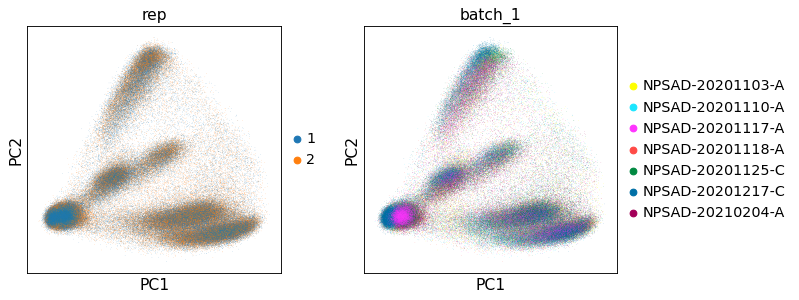

In [50]:
sc.pl.pca(adata[adata.obs['batch_1'].isin(select_samp.tolist())], components='1,2', color=['rep', 'batch_1'], color_map='viridis', save=False, show=True)

... storing 'batch_1' as categorical


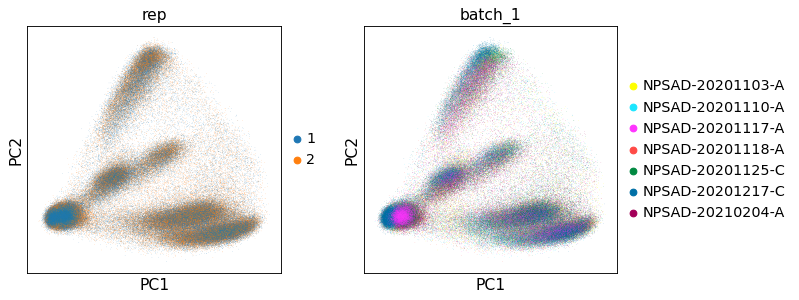

In [54]:
sc.pl.pca(adata_ch, components='1,2', color=['rep', 'batch_1'], color_map='viridis', save=False, show=True)

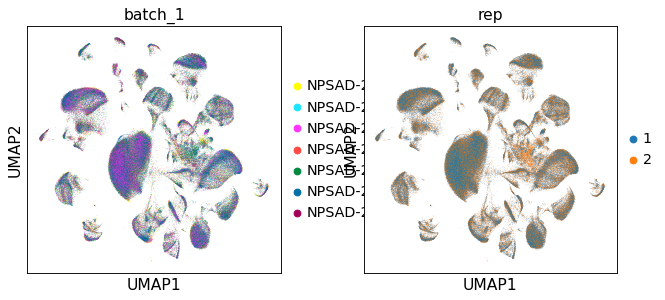

In [56]:
sc.pl.umap(adata_ch, color=['batch_1', 'rep'], save=False, show=True)

/sc/arion/work/prashf01/conda/envs/snakemake/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'batch_1' as categorical


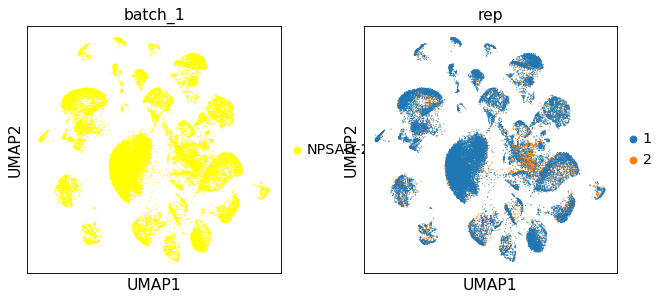

In [57]:
sc.pl.umap(adata[adata.obs['batch_1'] == select_samp.tolist()[0]], color=['batch_1', 'rep'], save=False, show=True, palette=[''])

In [58]:
Counter(adata[adata.obs['batch_1'] == select_samp.tolist()[0]].obs['rep'])

Counter({'2': 7609, '1': 25025})

In [59]:
Counter(adata[adata.obs['batch_1'] == select_samp.tolist()[1]].obs['rep'])

Counter({'1': 19830, '2': 21190})

In [60]:
Counter(adata[adata.obs['batch_1'] == select_samp.tolist()[2]].obs['rep'])

Counter({'2': 14997, '1': 17158})

In [61]:
Counter(adata[adata.obs['batch_1'] == select_samp.tolist()[3]].obs['rep'])

Counter({'2': 14997, '1': 17158})

In [62]:
Counter(adata[adata.obs['batch_1'] == select_samp.tolist()[4]].obs['rep'])

Counter({'2': 16659, '1': 16476})

In [63]:
Counter(adata[adata.obs['batch_1'] == select_samp.tolist()[5]].obs['rep'])

Counter({'1': 14184, '2': 23316})

Trying to set attribute `.obs` of view, copying.
... storing 'batch_1' as categorical


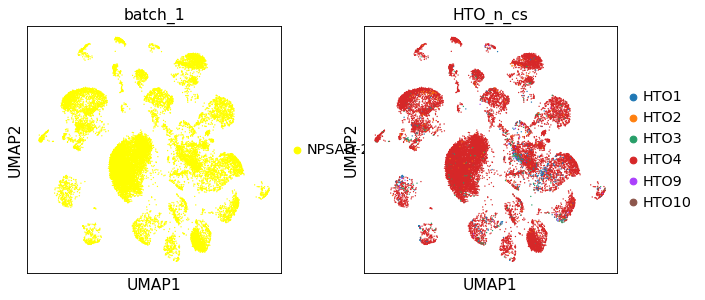

In [66]:
sc.pl.umap(adata[(adata.obs['batch_1'] == select_samp.tolist()[0]) & (adata.obs['HTO_n_cs'] != 'Not a Singlet')], color=['batch_1', 'HTO_n_cs'], save=False, show=True)

In [ ]:
sc.pl.umap(adata[adata.obs['HTO_n_cs'] != 'Not a Singlet'], color=['batch_1', 'HTO_n_cs'], save=False, show=True)

Trying to set attribute `.obs` of view, copying.


In [ ]:
sc.pl.umap(adata[adata.obs['HTO_n_ms'] != 'Not a Singlet'], color=['batch_1', 'HTO_n_ms'], save=False, show=True)

In [ ]:
sc.pl.umap(adata[adata.obs['HTO_n_hd'] != 'Not a Singlet'], color=['batch_1', 'HTO_n_hd'], save=False, show=True)

In [51]:
adata

AnnData object with n_obs × n_vars = 3518365 × 6160
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'batch', 'round_num', 'prep', 'rep', 'SubID_hd', 'HTO_n_hd', 'SubID_cs', 'SubID_ms', 'HTO_n_cs', 'HTO_n_ms', 'batch_1'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_1_colors', 'hvg', 'neighbors', 'pca', 'prep_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [21]:
save_annd(adata, 'hpy_umap')

In [ ]:
sc.tl.score_genes_cell_cycle(adata, s_genes=cs_s_genes['genes'], g2m_genes=cs_g2m_genes['genes'], save='STAR_cc_hvg_1k.png' if select == 'STAR' else 'cellR_cc_hvg_1k.png')